In [2]:
using LowRankVortex

┌ Info: Precompiling LowRankVortex [fdf095b8-6f21-420b-9d49-8e692abb03d1]
└ @ Base loading.jl:1664


In [67]:
using Distributions
using LinearAlgebra
using GaussianMixtures

In [4]:
using Plots

This notebook contains examples of several basic uses of probability tools for solving problems.

### Box-Muller algorithm
This is a simple method for transforming samples from a pair of uniform distributions (between 0 and 1)
into samples from a 2D unit Gaussian distribution

In [8]:
"Return a pair of variables with unit Gaussian distributions"
function boxmuller(n)
    z1, z2 = rand(n), rand(n);
    @. z1 = 2.0*z1 - 1
    @. z2 = 2.0*z2 - 1
    r2 = z1.^2 .+ z2.^2
    idx = findall(x -> x < 1, r2);
    y1 = [z1[i].*(-2*log.(r2[i])./r2[i]).^(1/2) for i in idx]
    y2 = [z2[i].*(-2*log.(r2[i])./r2[i]).^(1/2) for i in idx];
    return y1, y2
end

boxmuller

In [9]:
n = 50000
y1, y2 = boxmuller(n)

([0.781523145717423, 0.7479681653718017, 0.06846549847593456, 0.5653308584232065, 0.635643562402522, 0.15226315510406735, -0.3899903402570565, -0.1092363057788301, 0.04585356009617637, -0.8641579222143495  …  0.8706372514281704, 0.3855637191157282, 0.026909039840801924, -1.7120855637140155, 0.3932936584245688, -0.18648512560336628, -1.8339905592037153, -0.35102765007006487, -0.5177653350130567, 0.8635007321866283], [0.8481656700608589, 0.24336206254364776, 0.7941890851194652, 1.8105324725054641, 0.4187720016019574, -0.2089408189495477, 0.9308094568577594, 0.9255150998417156, 0.19690320068520664, 0.06207307158632582  …  0.9495078011296426, 0.03710489677028584, -0.30141048247647356, 1.032169461003216, -0.6191675802278765, -1.062113868203319, -0.8729950159695649, 0.08679779131886967, 0.7693502038820977, -0.06664374840434893])

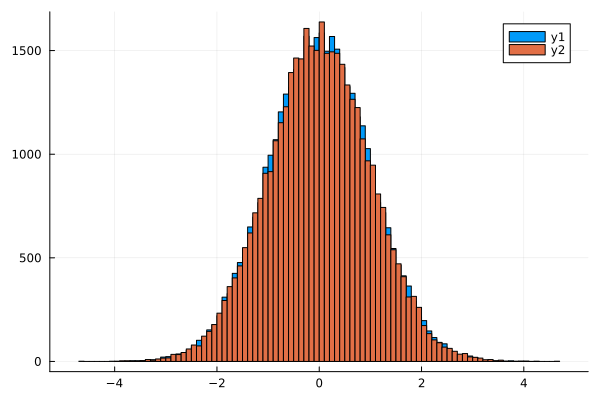

In [10]:
histogram(y1)
histogram!(y2)

### Gaussian mixture
Here, we will create a PDF of a Gauss mixture and then draw samples from it.

$$p(x) = \sum_{k=1}^K \pi_k N(x|\mu_k,\Sigma_k)$$

First we set the mixture coefficients $\pi_k$

In [11]:
coeffs = [0.2, 0.5, 0.4];
coeffs /= sum(coeffs) # normalized, so they add to 1

3-element Vector{Float64}:
 0.18181818181818182
 0.45454545454545453
 0.36363636363636365

Create each of the Gaussians

In [12]:
d = MvNormal[]

μ1 = [-2.0,-0.5]

# Specify each covariance matrix via principal axes of the ellipse
var11, var12 = 0.5,0.05
α1 = 0.0
X = [cos(α1) sin(α1); -sin(α1) cos(α1)]
Σ1 = X'*Diagonal([var11,var12])*X
push!(d,MvNormal(μ1,Σ1))

μ2 = [0.5,0.2];
var21, var22 = 0.5,0.05
α2 = π/4
X = [cos(α2) sin(α2); -sin(α2) cos(α2)]
Σ2 = X'*Diagonal([var21,var22])*X
push!(d,MvNormal(μ2,Σ2))

μ3 = [-2.0,2.0];
var31, var32 = 0.5,0.05
α3 = -π/4
X = [cos(α3) sin(α3); -sin(α3) cos(α3)]
Σ3 = X'*Diagonal([var31,var32])*X
push!(d,MvNormal(μ3,Σ3)) # Now d is a vector of Gaussian distributions

# Create the mixture model
dm = MixtureModel(d, coeffs);

Create a multinomial distribution (with N=1 samples) for $p(z|\pi)$ according to the mixture coefficients $\pi_k$.
A sample drawn from this distribution will be a multinomial of the 1-of-K form, e.g., [1,0,0], [0,1,0], or [0,0,1] 

In [13]:
pz = Multinomial(1,coeffs)

Multinomial{Float64, Vector{Float64}}(n=1, p=[0.18181818181818182, 0.45454545454545453, 0.36363636363636365])

Let's see how this works. First, we generate a bunch of samples

In [30]:
nsamp = 10000
zsamp = rand(pz,nsamp);

This is a list of samples of 1-of-K vectors. We need to convert this into samples taking the value 1, 2, or 3. Here's one way to do that:

In [27]:
z_int = map(z -> findmax(z)[2],eachcol(zsamp));

Now let's plot the histogram

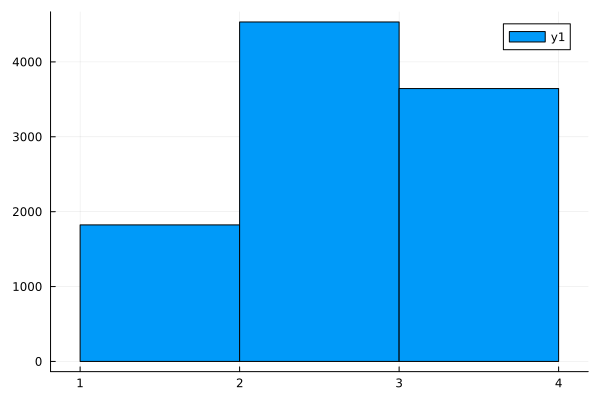

In [28]:
histogram(z_int,bins=3)

Now we are ready to draw samples $(x,z)$ from the joint distribution $p(x,z)$. First, we sample from $\hat{z} \sim p(z|\pi)$ (actually, we just did that), and then we sample from $p(x|\hat{z})$.

In [35]:
data = [Matrix{Float64}(undef,2,0) for i = 1:3]

for n in 1:nsamp
    component = z_int[n] # sample n belongs to component z_int[n]
    x_trial = rand(d[component]) # draw from the Gaussian numbered z_int[n]
    data[component] = hcat(data[component],x_trial) # add this sample to the list
end

Now plot the samples, coloring them according to which Gaussian component they are in

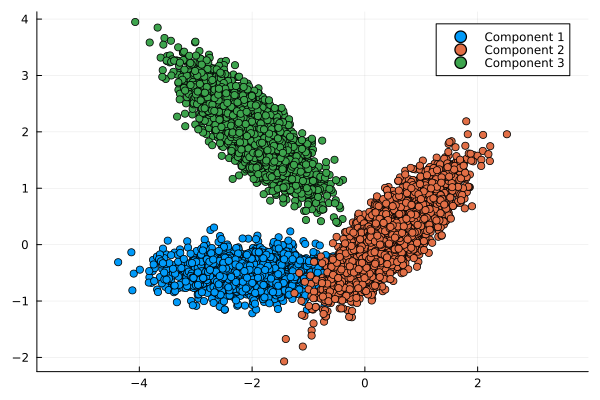

In [32]:
scatter(data[1][1,:],data[1][2,:],ratio=1,label="Component 1")
scatter!(data[2][1,:],data[2][2,:],label="Component 2")
scatter!(data[3][1,:],data[3][2,:],label="Component 3")

We were able to generate this plot because the data was *complete*: we knew the component that each sample belonged to, because we generated the data with this knowledge and were able to group them accordingly. But if we didn't know this ahead of time (which means the data is *incomplete*), but we were interested in determining the *responsibility* of each component (i.e., the likelihood $p(z|x)$ of $z$ given a sample $x$), then we would compute it this way:

In [43]:
alldata = hcat(data...) # put all the x samples together into one array
resp = [zeros(nsamp) for k = 1:3]
for k = 1:3
    for i in 1:size(alldata,2)
        x = alldata[:,i] 
        resp[k][i] = coeffs[k]*pdf(d[k],x)/pdf(dm,x) # responsibility of component k for sample i
    end
end

Now plot each $x$ sample, but color it by its responsibility. Notice how it colors most of the points by a solid RGB color, but some of them at the intersections are of "mixed" responsibility.

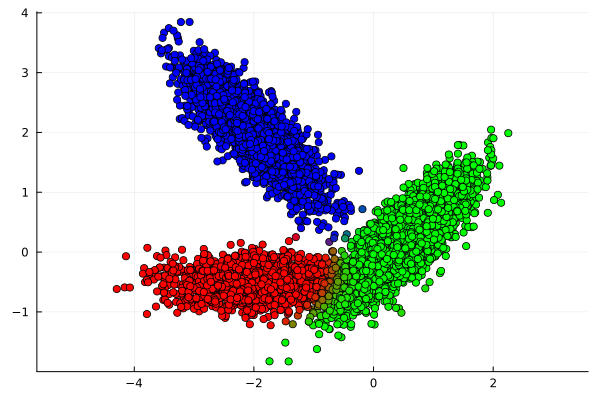

In [45]:
scatter(alldata[1,:],alldata[2,:],ratio=1,color=RGBA{Float64}.(resp[1],resp[2],resp[3],1),legend=false)

### MCMC Metropolis-Hastings
Here, we are interested in using the Metropolis-Hastings algorithm to sample from a probability density function. All we need is the ability to evaluate the pdf, $p(x)$, for any sample $x$. In fact, we don't even need $p$ itself, but knowledge of $p$ up to a constant of proportionality. We will call this $\tilde{p}(x)$. And, in fact, we will use the log of this, $\log \tilde{p}$.

In [68]:
# Define the log-probability. Here, we are just using a single Gaussian pdf

var1, var2 = 1.0,0.05
α = π/3
R = [cos(α) sin(α); -sin(α) cos(α)]
Σ = R'*Diagonal([var1,var2])*R
μ = [0.0,1.0]
function logp̃(x)
    loss = norm(x - μ,Σ)
    return -loss^2/2
end

logp̃ (generic function with 1 method)

As for any MCMC algorithm, the M-H generates a Markov chain -- a set of samples in which each new sample is proposed from the previous sample, based on looking in a neighborhood around it. It chooses a new sample based on whether it is more probable than the previous one. If it is not more probable, then we say that the proposal is *not accepted* and the next chain link remains at its previous value.

Let's run the algorithm for 10000 steps. We only need to supply the initial seed sample (x = [0,0]), the log-probability function, and a variance of the "proposal" probability, which controls how far away to look for the next sample from the current sample. Note that the algorithm discards the first half of the data, because we assume that there is a "burn-in" period while it forgets the initial seed.

In [74]:
Ntrial = 10000
x = [0.0,0.0]
propvar = 0.2
X, accept = metropolis(x,Ntrial,logp̃,propvar);

Here's how many proposals were actually accepted:

In [75]:
count(accept)

2323

Let's plot the chain

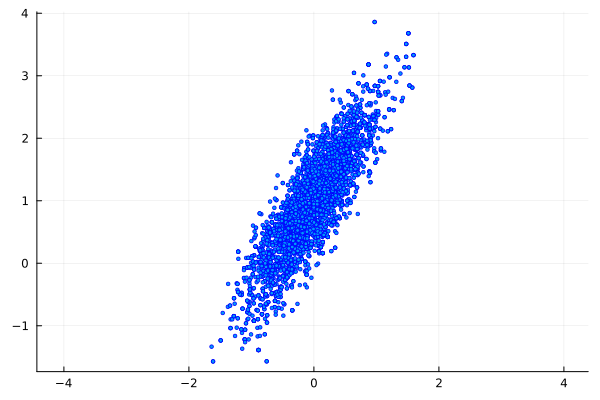

In [98]:
scatter(X[1,:],X[2,:],ratio=1,legend=false,markersize=2,markerstrokecolor=:blue)

In [77]:
X

Ensemble with 5001 members of 2-dimensional data
2×5001 Matrix{Float64}:
 0.965609  0.680981  0.680981  0.680981  …  0.23814  0.532039  -0.178775
 1.83885   2.34202   2.34202   2.34202      1.75044  1.55611    1.1761

### Identification of a Gauss mixture model

Now, let's suppose we didn't know what distribution these samples came from. We can try to identify a Gaussian that best fits the data. This is done by maximizing the likelihood: we assume that the data $X$ is described by a multivariate normal distribution (here, two variables), so that the likelihood function is $p(X|\mu,\Sigma)$. The result of maximizing this over $\mu$ and $\Sigma$ leads to a straightforward result: the mean and covariance of the Gaussian that best fits the data are simply the mean and covariance of the data itself:

In [120]:
μ_mod = mean(X)

2-element Vector{Float64}:
 -0.014200209188154492
  0.9775283993244825

In [121]:
Σ_mod = cov(X)

2×2 Matrix{Float64}:
 0.247491  0.344176
 0.344176  0.648007

It is worth comparing these with the original values of the pdf we sampled from:

In [89]:
μ

2-element Vector{Float64}:
 0.0
 1.0

In [90]:
Σ

2×2 Matrix{Float64}:
 0.2875    0.411362
 0.411362  0.7625

so they are a bit different, but not far off. It gets better with more samples, of course. Let's draw ellipses to compare the original and the modeled distributions:

In [188]:
function draw_ellipse(μ::Vector,Σ::AbstractMatrix)
    θ = range(0,2π,length=100)
    xc, yc = cos.(θ), sin.(θ)
    sqrtΣ = sqrt(Σ)
    xell = μ[1] .+ sqrtΣ[1,1]*xc .+ sqrtΣ[1,2]*yc
    yell = μ[2] .+ sqrtΣ[2,1]*xc .+ sqrtΣ[2,2]*yc
    return xell,yell
end

draw_ellipse (generic function with 2 methods)

In [122]:
xe_model, ye_model = draw_ellipse(μ_mod,Σ_mod);
xe_orig, ye_orig = draw_ellipse(μ,Σ);

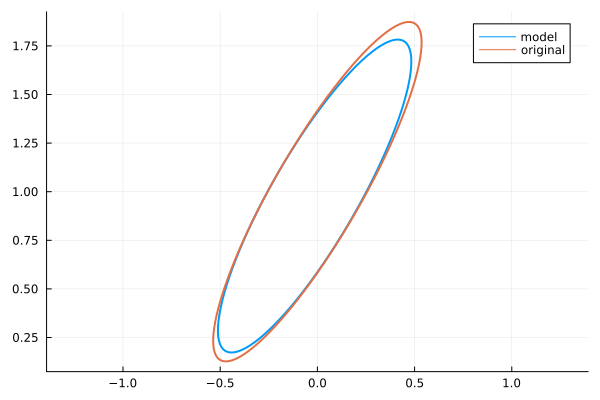

In [123]:
plot(xe_model,ye_model,ratio=1,linewidth=2,label="model")
plot!(xe_orig,ye_orig,linewidth=2,label="original")

In [119]:
distx2 = Normal(μ[2],Σ[2,2])
distx1x2 = Normal(mean(X)[1],cov(X)[1,1])

Normal{Float64}(μ=-0.014200209188154492, σ=0.24749100971190724)

### Multi-modal MH
What if the distribution that we are sampling from has more than one peak? A feature of Metropolis-Hastings is that, once it finds a region of high probability, it gets stuck in that region. This makes it valuable for generating a lot of samples for a single-mode distribution, but not very good for sampling a distribution with multiple modes.

Here is an example, where the distribution is

$$\tilde{p}(x_1,x_2) = \exp\left[-1000((x_1^2-1)^2+(x_2^2-1)^2)\right]$$

This has four peaks, at $(x_1,x_2) = (\pm 1, \pm 1)$. The factor of 1000 ensures that the peaks are well separated, making it difficult to move between peaks. We might think of this probability as an optimization problem, where our goal is to find the roots of the non-linear equation $(x_1^2-1)^2+(x_2^2-1)^2 = 0$, but with noise uncertainty in our trust of this relationship (described by $1/\sqrt{1000}$). Obviously we know the roots here, but in many similar examples we do not know them and seek to find them.

In [135]:
logp̃_scalar(x) = -1000*(x^2-1)^2

logp̃(x) = logp̃_scalar(x[1]) + logp̃_scalar(x[2])

logp̃ (generic function with 1 method)

Let's run M-H on this, starting at $(1,1)$.

In [136]:
xseed = [1.0,1.0]
Ntrial = 10000
propvar = 0.1^2
x_data, accept = metropolis(xseed,Ntrial,logp̃,propvar,burnin=1);

As you can see, it generates plenty of samples around the mode where it started, but none near the other three modes.

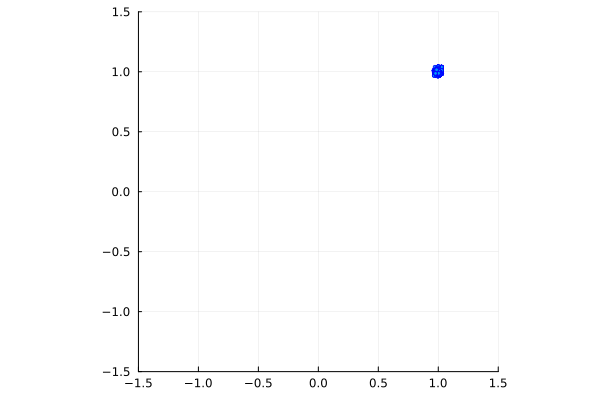

In [148]:
scatter(x_data[1,:],x_data[2,:],ratio=1,xlim=(-1.5,1.5),ylim=(-1.5,1.5),markersize=2,markerstrokecolor=:blue,legend=false)

What we need is a way for the Markov chain to find other modes occasionally and sample from them. For this, we can make use of the method of parallel tempering (or replica exchange MCMC sampling). In this technique, several chains are started at once (from the same initial guess). However, each one samples the probability distribution at a different "temperature". Those at a higher temperature have shallower wells around each mode, so it is easier for their chains to explore other areas of the state space (and find other wells). Occasionally, we can compare the states of two chains at different temperatures. We swap their states if doing so would be more favorable, according to a M-H criterion.

Let's try 5 chains, in which the first chain is at temperature 1 (i.e. the desired probability), and each other is at a higher temperature by an order of magnitude.Note that we also scale the proposal variances, using larger variances at larger temperatures.

In [151]:
nchain = 5
β = 10.0.^(range(0,-3,length=nchain)) # inverse temperatures
xseeds = [[1.0,1.0] for i in 1:nchain]; # Same initial guess for each
propvars = 0.05^2*ones(nchain)./β # proposal variances get larger to make it easier to explore

5-element Vector{Float64}:
 0.0025000000000000005
 0.01405853312975873
 0.0790569415042095
 0.4445698525097308
 2.5000000000000004

Let's run it for 10000 steps

In [152]:
Ntrial = 10000
x_data, accept_data, logp_data, swaps, swapaccepts = metropolis(xseeds,Ntrial,logp̃,propvars;burnin=1,β=β);

It is useful to look at the fraction of swap opportunities that are actually accepted. A rule of thumb is that we would like these to be around 1/3 -- that is, if a swap opportunity is accepted 1 out of every 3 times, then it means we are doing a fairly good job of exploring the space.

In [153]:
swapaccepts./swaps

4-element Vector{Float64}:
 0.32533972821742607
 0.3191235059760956
 0.25770750988142294
 0.26455026455026454

In [132]:
count.(accept_data)/length(accept_data[1])

5-element Vector{Float64}:
 0.0834
 0.0863
 0.0915
 0.1098
 0.2612

Let's check the resulting samples in the first (coldest) chain. As you can see, it does a good job of finding all four modes, even though it started near the $(1,1)$ mode.

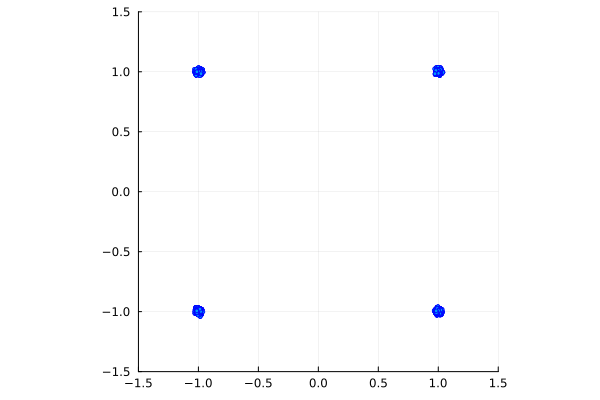

In [155]:
scatter(x_data[1][1,:],x_data[1][2,:],ratio=1,xlim=(-1.5,1.5),ylim=(-1.5,1.5),markersize=2,markerstrokecolor=:blue,legend=false)

In [164]:
x_fulldata = zeros(size(transpose(x_data[1])))
x_fulldata .= transpose(x_data[1]);

Let's fit a Gauss mixture model to these samples. A mixture model uses $n$ Gaussian components, where the weights, means, and covariances of the Gaussians are initially undetermined.

During training, the method attempts to determine the membership of each data point (which component it belongs to), and then optimizes the means and variances of each Gaussian based on these memberships. It iterates on this process.

In [184]:
gm = GMM(4,x_fulldata,method=:kmeans,nIter=30);

K-means converged with 2 iterations (objv = 0.9901512036158442)


┌ Info: Initializing GMM, 4 Gaussians diag covariance 2 dimensions using 10000 data points
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:79
┌ Info: K-means with 4000 data points using 2 iterations
│ 333.3 data points per parameter
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:141
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3, 4]
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3, 4]
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3, 4]
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:260
┌ Warning: Variances had to be floored 
│   ind = [1, 2, 3, 4]
└ @ GaussianMixtures /Users/jeff/.julia/packages/GaussianMixtures/zDaBV/src/train.jl:260
┌ Warning: Variances had to be fl

Let's check out the means and variances. It successfully finds all of the modes, and estimates the variances to be on the order of 1e-4:

In [185]:
means(gm)

4×2 Matrix{Float64}:
 -0.999439   1.00001
  0.999195  -0.999054
  0.999381   1.00067
 -1.00015   -0.99761

In [200]:
covars(gm)

4×2 Matrix{Float64}:
 0.000132748  0.000113992
 0.000114559  0.000150332
 0.000110449  0.00013128
 0.000116737  0.000116824

Plot them:

In [192]:
xe1, ye1 = draw_ellipse(means(gm)[1,:],Diagonal(covars(gm)[1,:]));
xe2, ye2 = draw_ellipse(means(gm)[2,:],Diagonal(covars(gm)[2,:]));
xe3, ye3 = draw_ellipse(means(gm)[3,:],Diagonal(covars(gm)[3,:]));
xe4, ye4 = draw_ellipse(means(gm)[4,:],Diagonal(covars(gm)[4,:]));

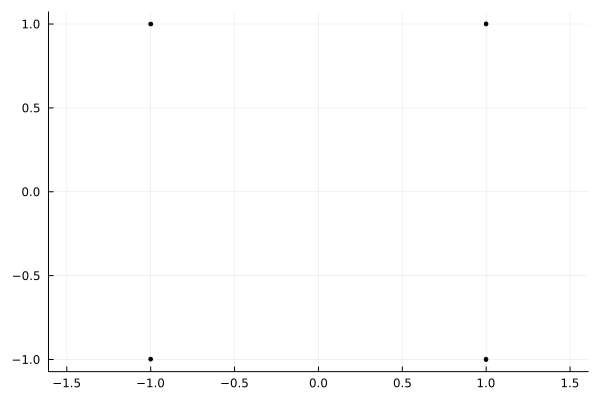

In [198]:
plot(xe1,ye1,ratio=1,legend=false,fill=true,color=:black)
plot!(xe2,ye2,fill=true,color=:black)
plot!(xe3,ye3,fill=true,color=:black)
plot!(xe4,ye4,fill=true,color=:black)